In [1]:
# coding=utf8
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn import linear_model, tree, svm, naive_bayes, neighbors
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

train_features_quanju = np.loadtxt("quanju_1.csv", delimiter=",")
test_features_quanju = np.loadtxt("quanju_test_1.csv", delimiter=",")
train_features_zhongliu = np.loadtxt("zhongliu.csv", delimiter=",")
test_features_zhongliu = np.loadtxt("zhongliu_test.csv", delimiter=",")
train_features_bydai = np.loadtxt("bydai.csv", delimiter=",")
test_features_bydai = np.loadtxt("bydai_test.csv", delimiter=",")
train_features_huisheng = np.loadtxt("huisheng.csv", delimiter=",")
test_features_huisheng = np.loadtxt("huisheng_test.csv", delimiter=",")

pca = PCA(n_components=10,random_state=30)
a = pca.fit(train_features_quanju)
# print(pca.explained_variance_ratio_)
# print('----------------------------------')
# print(pca.explained_variance_)
train_quanju = pca.transform(train_features_quanju)
test_quanju = pca.transform(test_features_quanju)
train_zhongliu = pca.transform(train_features_zhongliu)
test_zhongliu = pca.transform(test_features_zhongliu)
train_bydai = pca.transform(train_features_bydai)
test_bydai = pca.transform(test_features_bydai)
train_huisheng = pca.transform(train_features_huisheng)
test_huisheng = pca.transform(test_features_huisheng)

train_labels = np.loadtxt("Y_train.csv", delimiter=",")
test_labels = np.loadtxt("Y_test.csv", delimiter=",")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
test_quanju.shape,test_zhongliu.shape,test_bydai.shape,test_huisheng.shape

((120, 10), (120, 10), (120, 10), (120, 10))

In [3]:
train_quanju.shape,train_zhongliu.shape,train_bydai.shape,train_huisheng.shape

((359, 10), (359, 10), (359, 10), (359, 10))

In [4]:
x1 = np.hstack((train_quanju,train_zhongliu,train_bydai,train_huisheng))
x2 = np.hstack((test_quanju,test_zhongliu,test_bydai,test_huisheng))
# x1 = np.hstack((train_features_quanju,train_features_zhongliu))
# x2 = np.hstack((test_features_quanju,test_features_zhongliu))
data = np.vstack((x1,x2))

label = np.hstack((train_labels,test_labels))

In [5]:
'''模型融合中使用到的各个单模型'''
# n_jobs 用于拟合和预测的并行运行的工作（作业）数量。如果值为-1，那么工作数量被设置为核的数量。
# criterion 衡量分裂质量的性能（函数）。 受支持的标准是基尼不纯度的"gini",和信息增益的"entropy"（熵）
clfs = [
        linear_model.LogisticRegression(),
#         RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
#         RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
#         ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
#         ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
#         GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5),
        tree.DecisionTreeClassifier(criterion='entropy', random_state=1),
#         RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy', random_state=1),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy', random_state=1),
#         AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20, min_samples_leaf=5),
#                          algorithm="SAMME",
#                          n_estimators=50, learning_rate=0.8),
        svm.SVC(kernel='rbf',probability=True, random_state=1),     
#         naive_bayes.GaussianNB(),
#         GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5, random_state=1),
        neighbors.KNeighborsClassifier(n_neighbors=5)
       ]   

'''切分一部分数据作为测试集'''
# X, X_predict, y, y_predict = train_test_split(data, label, test_size=0.33, random_state=2017)
X = x1
X_predict = x2
# X = train_huisheng
# X_predict = test_huisheng
y = train_labels
y_predict = test_labels

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

stratified_folder = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
# for train_index, test_index in stratified_folder.split(X, y):
#     print("Stratified Train Index:", train_index)
#     print("Stratified Test Index:", test_index)
#     print("Stratified y_train:", y[train_index])
#     print("Stratified y_test:", y[test_index],'\n')


In [6]:
for j, clf in enumerate(clfs):
    '''依次训练各个单模型'''
    # print(j, clf)
    dataset_blend_test_j = np.zeros((X_predict.shape[0], 5))
    # for i, (train, test) in sfolder.split(X,y):
    i=0
    for train_index, test_index in stratified_folder.split(X, y):
        '''使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。'''
        # print("Fold", i)
#         print(i)
#         print(train_index)
#         print(test_index)
#         print('----------------------------------------------------------')
        X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
        clf.fit(X_train, y_train)
        y_sub_1 = clf.predict_proba(X_test)
        y_submission_1 = y_sub_1[:, 1]
#         print(j,i,"val auc Score: %f" % roc_auc_score(y_test, y_submission_1))
        dataset_blend_train[test_index, j] = y_submission_1
        test_ = clf.predict_proba(X_predict)
        dataset_blend_test_j[:, i] = test_[:, 1]
        i+=1
    '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_blend_test[:, j]))
    print("accuracy: %f" % accuracy_score(y_predict,np.argmax(test_, axis=1)))
# clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30, random_state=100)
clf = svm.SVC(kernel='linear',probability=True, random_state=1)
# clf = linear_model.LogisticRegression()
clf.fit(dataset_blend_train, y)
y_sub_2 = clf.predict_proba(dataset_blend_test)
y_submission = y_sub_2[:, 1]

print("Linear stretch of predictions to [0,1]")
y_submission_final = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())
print("blend result")
print("val auc Score: %f" % (roc_auc_score(y_predict, y_submission_final)))
print("accuracy: %f" % accuracy_score(y_predict,np.argmax(y_sub_2, axis=1)))
from sklearn.metrics import classification_report
print(classification_report(y_predict,np.argmax(y_sub_2, axis=1),target_names=['benign','mallignant']))

val auc Score: 0.850308
accuracy: 0.841667
val auc Score: 0.782892
accuracy: 0.791667
val auc Score: 0.841609
accuracy: 0.725000
val auc Score: 0.823849
accuracy: 0.783333
val auc Score: 0.829648
accuracy: 0.791667
Linear stretch of predictions to [0,1]
blend result
val auc Score: 0.872418
accuracy: 0.850000
             precision    recall  f1-score   support

     benign       0.88      0.92      0.90        89
 mallignant       0.74      0.65      0.69        31

avg / total       0.85      0.85      0.85       120



In [10]:
dataset_blend_train

array([[0.01621983, 0.        , 0.2       , 0.04478447, 0.        ],
       [0.96962575, 0.        , 0.2       , 0.52626129, 0.4       ],
       [0.0039766 , 0.        , 0.        , 0.16970815, 0.        ],
       ...,
       [0.18538031, 1.        , 0.8       , 0.52312109, 0.8       ],
       [0.15804781, 0.        , 0.        , 0.06547633, 0.        ],
       [0.49220164, 1.        , 0.8       , 0.68398864, 0.8       ]])

In [7]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
y_score4 = clf.fit(dataset_blend_train, y).decision_function(dataset_blend_test)
fpr4,tpr4,threshold4 = roc_curve(y_predict, y_score4) 
roc_auc4 = auc(fpr4,tpr4)

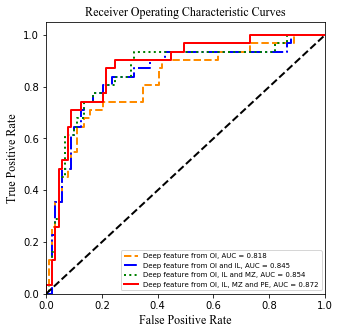

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn import model_selection
# -*- coding: utf-8 -*-

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 12,
}

# plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr1, tpr1, color='darkorange',ls='--',
         lw=lw, label='Deep feature from OI, AUC = %0.3f' % roc_auc1) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr2, tpr2, color='blue',ls='-.',
         lw=lw, label='Deep feature from OI and IL, AUC = %0.3f' % roc_auc2) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr3, tpr3, color='green',ls=':',
         lw=lw, label='Deep feature from OI, IL and MZ, AUC = %0.3f' % roc_auc3) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr4, tpr4, color='red',
         lw=lw, label='Deep feature from OI, IL, MZ and PE, AUC = %0.3f' % roc_auc4) ###假正率为横坐标，真正率为纵坐标做曲线

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',font1)
plt.ylabel('True Positive Rate',font1)
plt.title('Receiver Operating Characteristic Curves',font1)
plt.legend(loc="lower right",fontsize=7)
plt.savefig('ROC.png', dpi=1000, bbox_inches='tight')
plt.show()
